# MNIST Handwritten Digit Classification - Prediction & Visualization

This notebook performs predictions and visualizes the internal workings of the CNN model

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060


## 2. Configuration

In [2]:
CONFIG = {
    'batch_size': 64,
    'num_classes': 10,
    'model_path': 'models/best_mnist_model.pth',
    'test_data_path': 'digit-recognizer/test.csv',
    'submission_path': 'submission.csv',
    'visualization_dir': 'visualizations/'
}

# Create visualization directory
os.makedirs(CONFIG['visualization_dir'], exist_ok=True)

print("Configuration loaded!")

Configuration loaded!


## 3. Define Model Architecture (Same as Training)

In [3]:
class MNISTNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MNISTNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

print("Model architecture defined!")

Model architecture defined!


## 4. Load Trained Model

In [4]:
# Initialize model
model = MNISTNet(num_classes=CONFIG['num_classes']).to(device)

# Load checkpoint
checkpoint = torch.load(CONFIG['model_path'], map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set to evaluation mode

print(f"Model loaded successfully!")
print(f"Validation accuracy from training: {checkpoint['val_acc']:.2f}%")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model loaded successfully!
Validation accuracy from training: 99.49%
Total parameters: 437,738


## 5. Load Test Data

In [5]:
class MNISTTestDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx].reshape(28, 28).astype(np.float32)
        image = image / 255.0
        image = np.expand_dims(image, axis=0)
        image = torch.from_numpy(image)
        return image

# Load test data
test_df = pd.read_csv(CONFIG['test_data_path'])
X_test = test_df.values

print(f"Test samples: {len(X_test):,}")

# Create dataset and dataloader
test_dataset = MNISTTestDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

print(f"Test batches: {len(test_loader)}")

Test samples: 28,000
Test batches: 438


## 6. Feature Extraction with Hooks

In [6]:
class FeatureExtractor:
    """
    Extract intermediate layer outputs using hooks
    """
    def __init__(self, model):
        self.model = model
        self.features = {}
        self.hooks = []
        
    def register_hooks(self):
        """Register forward hooks to capture layer outputs"""
        
        def get_features(name):
            def hook(model, input, output):
                self.features[name] = output.detach()
            return hook
        
        # Register hooks for conv layers
        self.hooks.append(self.model.conv1.register_forward_hook(get_features('conv1')))
        self.hooks.append(self.model.conv2.register_forward_hook(get_features('conv2')))
        self.hooks.append(self.model.pool1.register_forward_hook(get_features('pool1')))
        
        self.hooks.append(self.model.conv3.register_forward_hook(get_features('conv3')))
        self.hooks.append(self.model.conv4.register_forward_hook(get_features('conv4')))
        self.hooks.append(self.model.pool2.register_forward_hook(get_features('pool2')))
        
        self.hooks.append(self.model.conv5.register_forward_hook(get_features('conv5')))
        self.hooks.append(self.model.pool3.register_forward_hook(get_features('pool3')))
        
        self.hooks.append(self.model.fc1.register_forward_hook(get_features('fc1')))
        self.hooks.append(self.model.fc2.register_forward_hook(get_features('fc2')))
        
    def remove_hooks(self):
        """Remove all hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        
    def get_features(self):
        """Return captured features"""
        return self.features

print("FeatureExtractor class defined!")

FeatureExtractor class defined!


## 7. Visualize Learned Filters

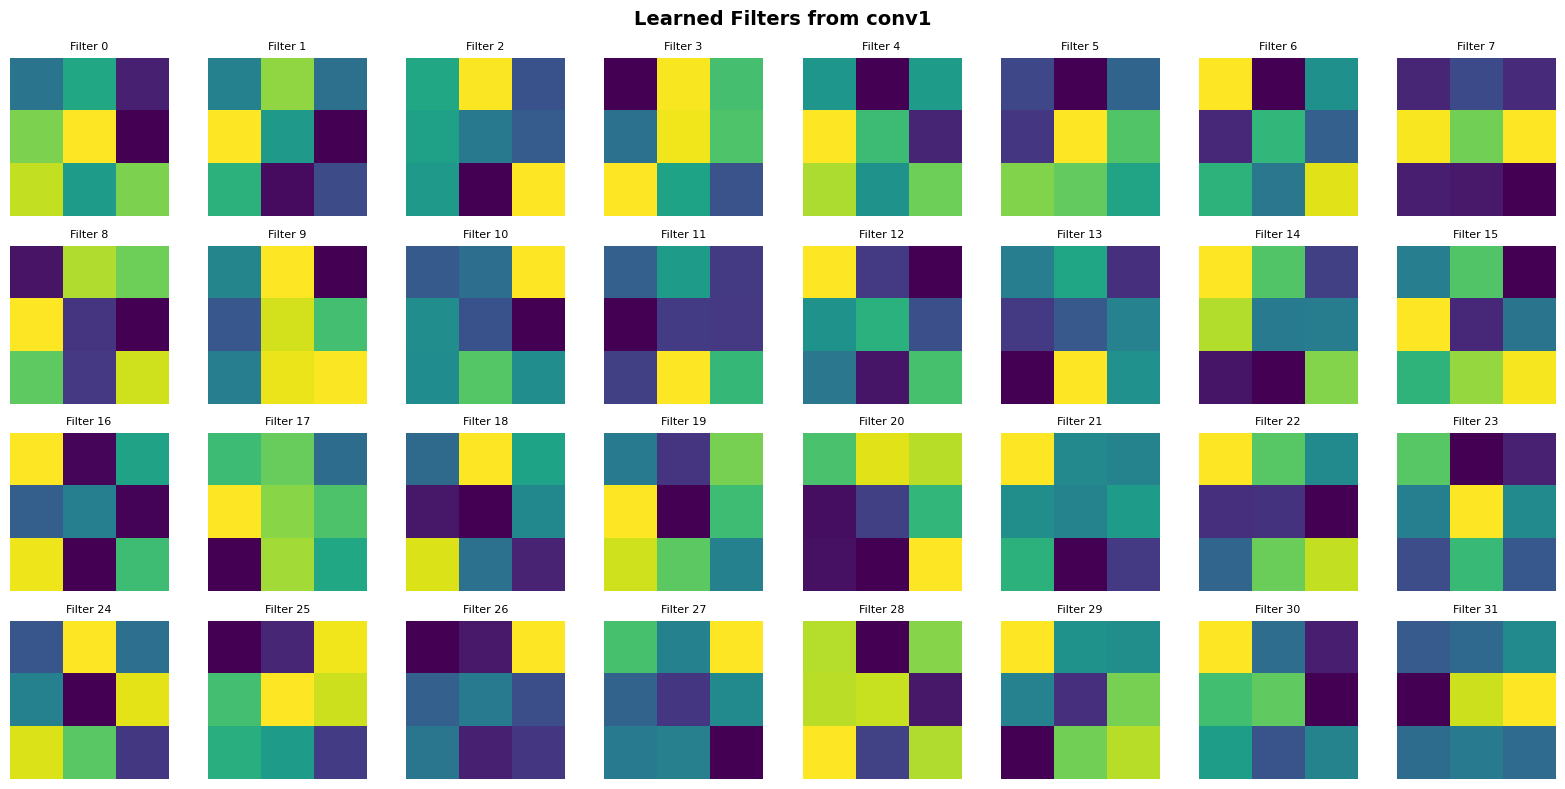


Filters visualized!


In [7]:
def visualize_filters(model, layer_name='conv1', num_filters=32):
    """
    Visualize learned filters from a convolutional layer
    """
    # Get the layer
    layer = dict(model.named_modules())[layer_name]
    
    # Get weights
    weights = layer.weight.data.cpu()
    
    # Normalize weights for visualization
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    
    # Plot filters
    num_show = min(num_filters, weights.shape[0])
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(num_show):
        if i >= len(axes):
            break
        # Get filter (take first channel if multiple input channels)
        filter_img = weights[i, 0, :, :].numpy()
        axes[i].imshow(filter_img, cmap='viridis')
        axes[i].set_title(f'Filter {i}', fontsize=8)
        axes[i].axis('off')
    
    # Hide remaining axes
    for i in range(num_show, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Learned Filters from {layer_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['visualization_dir'], f'filters_{layer_name}.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Visualize filters from conv1
visualize_filters(model, 'conv1', num_filters=32)
print("\nFilters visualized!")

## 8. Visualize Feature Maps for a Single Image

In [8]:
def visualize_feature_maps(image, features, layer_name, num_maps=16, save_prefix=''):
    """
    Visualize feature maps from a specific layer
    """
    feature_map = features[layer_name][0].cpu()  # Take first sample in batch
    num_channels = feature_map.shape[0]
    num_show = min(num_maps, num_channels)
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(num_show):
        fmap = feature_map[i].numpy()
        axes[i].imshow(fmap, cmap='viridis')
        axes[i].set_title(f'Channel {i}', fontsize=9)
        axes[i].axis('off')
    
    # Hide remaining axes
    for i in range(num_show, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Feature Maps from {layer_name}\n({num_channels} channels total)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_prefix:
        plt.savefig(os.path.join(CONFIG['visualization_dir'], 
                                 f'{save_prefix}_featuremaps_{layer_name}.png'), 
                   dpi=150, bbox_inches='tight')
    plt.show()

print("Feature map visualization function defined!")

Feature map visualization function defined!


## 9. Complete Prediction Visualization Pipeline

In [9]:
def visualize_complete_prediction(model, image_tensor, image_idx, true_label=None):
    """
    Complete visualization of the prediction process
    Shows: Original image -> Feature maps at each layer -> Final prediction
    """
    model.eval()
    
    # Setup feature extractor
    extractor = FeatureExtractor(model)
    extractor.register_hooks()
    
    # Forward pass
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
    
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class].item() * 100
    
    # Get features
    features = extractor.get_features()
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(4, 5, figure=fig, hspace=0.4, wspace=0.3)
    
    # 1. Original Image
    ax_orig = fig.add_subplot(gs[0, 0])
    original_img = image_tensor[0, 0].cpu().numpy()
    ax_orig.imshow(original_img, cmap='gray')
    title = f'Original Image\nPredicted: {predicted_class}'
    if true_label is not None:
        title += f'\nTrue: {true_label}'
    ax_orig.set_title(title, fontsize=12, fontweight='bold')
    ax_orig.axis('off')
    
    # 2. Conv1 output (sample channels)
    ax_conv1 = fig.add_subplot(gs[0, 1])
    conv1_mean = features['conv1'][0].mean(dim=0).cpu().numpy()
    ax_conv1.imshow(conv1_mean, cmap='viridis')
    ax_conv1.set_title(f'After Conv1\n(32 channels, 28x28)', fontsize=10)
    ax_conv1.axis('off')
    
    # 3. Pool1 output
    ax_pool1 = fig.add_subplot(gs[0, 2])
    pool1_mean = features['pool1'][0].mean(dim=0).cpu().numpy()
    ax_pool1.imshow(pool1_mean, cmap='viridis')
    ax_pool1.set_title(f'After Pool1\n(32 channels, 14x14)', fontsize=10)
    ax_pool1.axis('off')
    
    # 4. Conv3 output
    ax_conv3 = fig.add_subplot(gs[0, 3])
    conv3_mean = features['conv3'][0].mean(dim=0).cpu().numpy()
    ax_conv3.imshow(conv3_mean, cmap='viridis')
    ax_conv3.set_title(f'After Conv3\n(64 channels, 14x14)', fontsize=10)
    ax_conv3.axis('off')
    
    # 5. Pool2 output
    ax_pool2 = fig.add_subplot(gs[0, 4])
    pool2_mean = features['pool2'][0].mean(dim=0).cpu().numpy()
    ax_pool2.imshow(pool2_mean, cmap='viridis')
    ax_pool2.set_title(f'After Pool2\n(64 channels, 7x7)', fontsize=10)
    ax_pool2.axis('off')
    
    # 6. Conv5 output
    ax_conv5 = fig.add_subplot(gs[1, 0])
    conv5_mean = features['conv5'][0].mean(dim=0).cpu().numpy()
    ax_conv5.imshow(conv5_mean, cmap='viridis')
    ax_conv5.set_title(f'After Conv5\n(128 channels, 7x7)', fontsize=10)
    ax_conv5.axis('off')
    
    # 7. Pool3 output (final conv output)
    ax_pool3 = fig.add_subplot(gs[1, 1])
    pool3_mean = features['pool3'][0].mean(dim=0).cpu().numpy()
    ax_pool3.imshow(pool3_mean, cmap='viridis')
    ax_pool3.set_title(f'After Pool3\n(128 channels, 3x3)\nFlattened to 1152', fontsize=10)
    ax_pool3.axis('off')
    
    # 8. FC1 activations (bar plot of first 50 neurons)
    ax_fc1 = fig.add_subplot(gs[1, 2:4])
    fc1_activations = features['fc1'][0].cpu().numpy()[:50]
    ax_fc1.bar(range(len(fc1_activations)), fc1_activations, color='steelblue', alpha=0.7)
    ax_fc1.set_title(f'FC1 Activations (first 50 of 256 neurons)', fontsize=10)
    ax_fc1.set_xlabel('Neuron Index')
    ax_fc1.set_ylabel('Activation')
    ax_fc1.grid(alpha=0.3)
    
    # 9. Final output probabilities
    ax_probs = fig.add_subplot(gs[1, 4])
    probs = probabilities[0].cpu().numpy() * 100
    colors = ['green' if i == predicted_class else 'lightblue' for i in range(10)]
    ax_probs.barh(range(10), probs, color=colors, alpha=0.8)
    ax_probs.set_yticks(range(10))
    ax_probs.set_yticklabels([f'Digit {i}' for i in range(10)])
    ax_probs.set_xlabel('Probability (%)')
    ax_probs.set_title(f'Final Predictions\nConfidence: {confidence:.1f}%', fontsize=10, fontweight='bold')
    ax_probs.grid(alpha=0.3, axis='x')
    
    # 10-13. Sample feature maps from different layers
    layer_samples = [
        ('conv1', gs[2, :2]),
        ('conv3', gs[2, 2:4]),
        ('pool2', gs[2, 4]),
        ('conv5', gs[3, :2])
    ]
    
    for layer_name, grid_pos in layer_samples:
        if isinstance(grid_pos, slice):
            continue  # Skip for now, show in detail below
    
    # 14. Show Conv1 sample channels
    conv1_features = features['conv1'][0].cpu().numpy()
    ax_conv1_samples = [fig.add_subplot(gs[2, i]) for i in range(4)]
    for idx, ax in enumerate(ax_conv1_samples):
        if idx < conv1_features.shape[0]:
            ax.imshow(conv1_features[idx], cmap='viridis')
            ax.set_title(f'Conv1 Ch{idx}', fontsize=8)
        ax.axis('off')
    
    # 15. Show Conv5 sample channels
    conv5_features = features['conv5'][0].cpu().numpy()
    ax_conv5_samples = [fig.add_subplot(gs[3, i]) for i in range(4)]
    for idx, ax in enumerate(ax_conv5_samples):
        if idx < conv5_features.shape[0]:
            ax.imshow(conv5_features[idx], cmap='viridis')
            ax.set_title(f'Conv5 Ch{idx}', fontsize=8)
        ax.axis('off')
    
    # Overall title
    fig.suptitle(f'Complete CNN Prediction Process Visualization (Image #{image_idx})', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.savefig(os.path.join(CONFIG['visualization_dir'], f'complete_prediction_img{image_idx}.png'), 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    # Remove hooks
    extractor.remove_hooks()
    
    return predicted_class, confidence, features

print("Complete visualization function defined!")

Complete visualization function defined!


## 10. Test on Sample Images

Visualizing prediction process for sample images...
This will take some time due to detailed visualization.


Processing Image #0


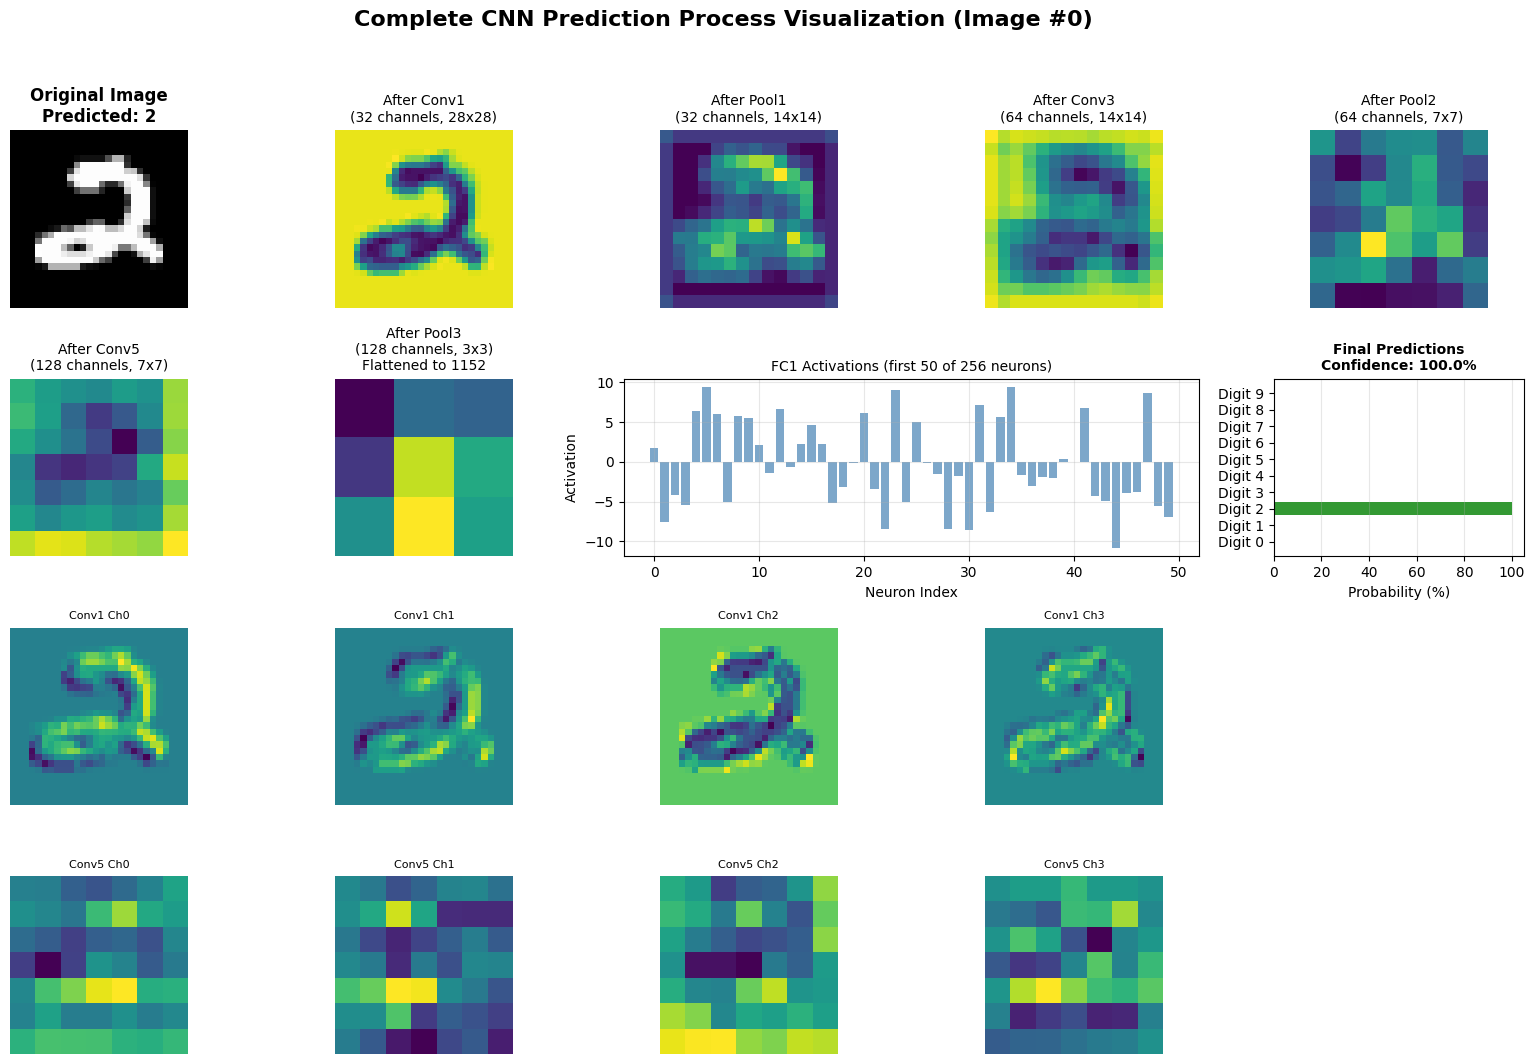

Predicted: 2 (Confidence: 100.00%)

Showing detailed feature maps for Conv1...


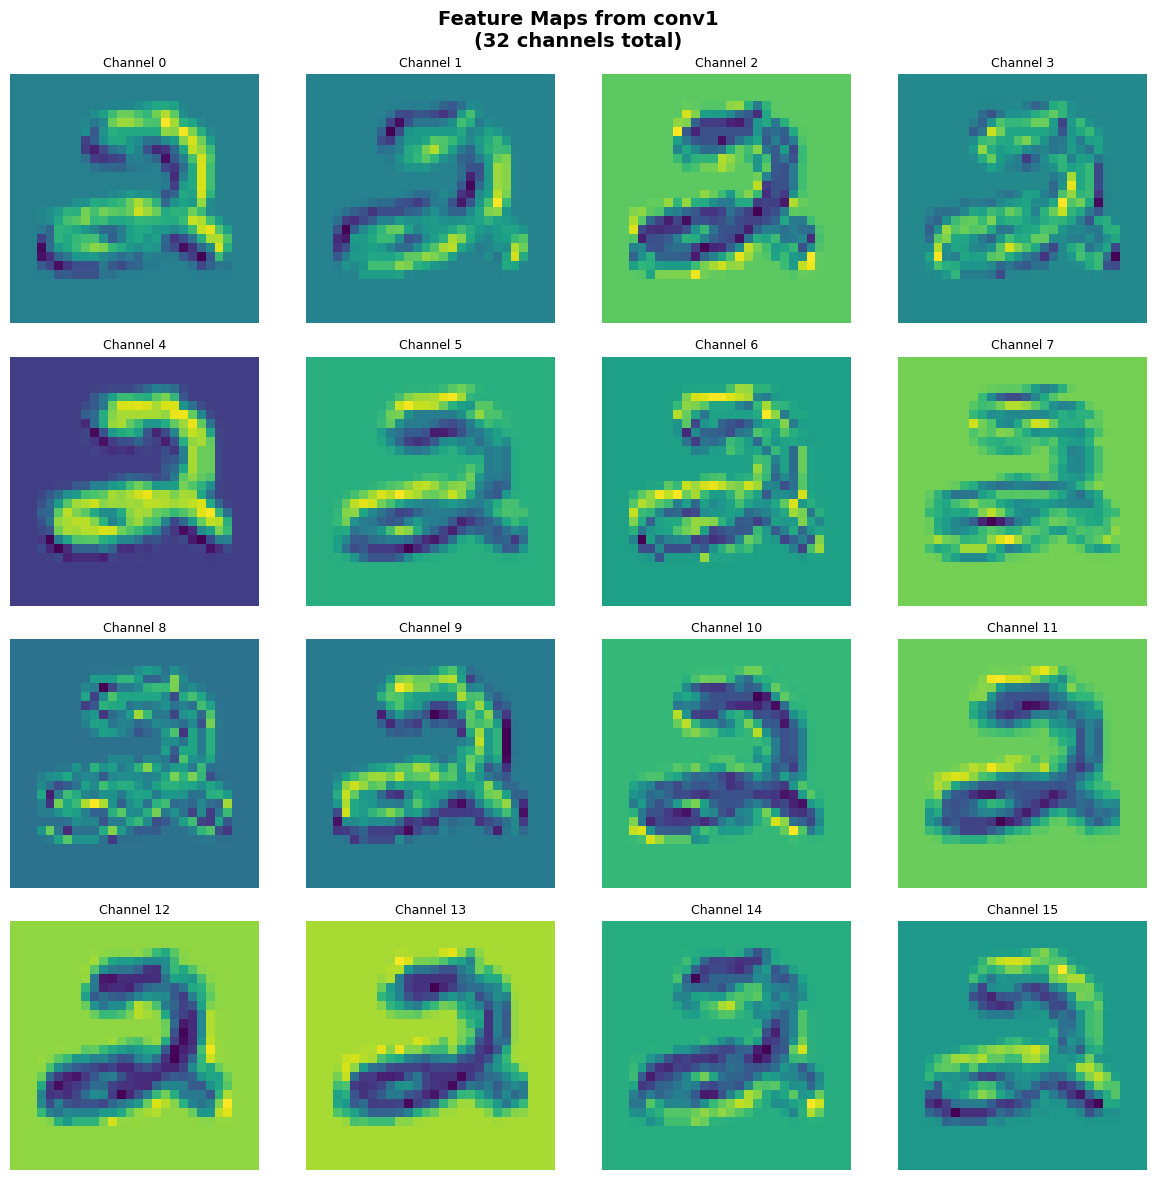


Showing detailed feature maps for Conv3...


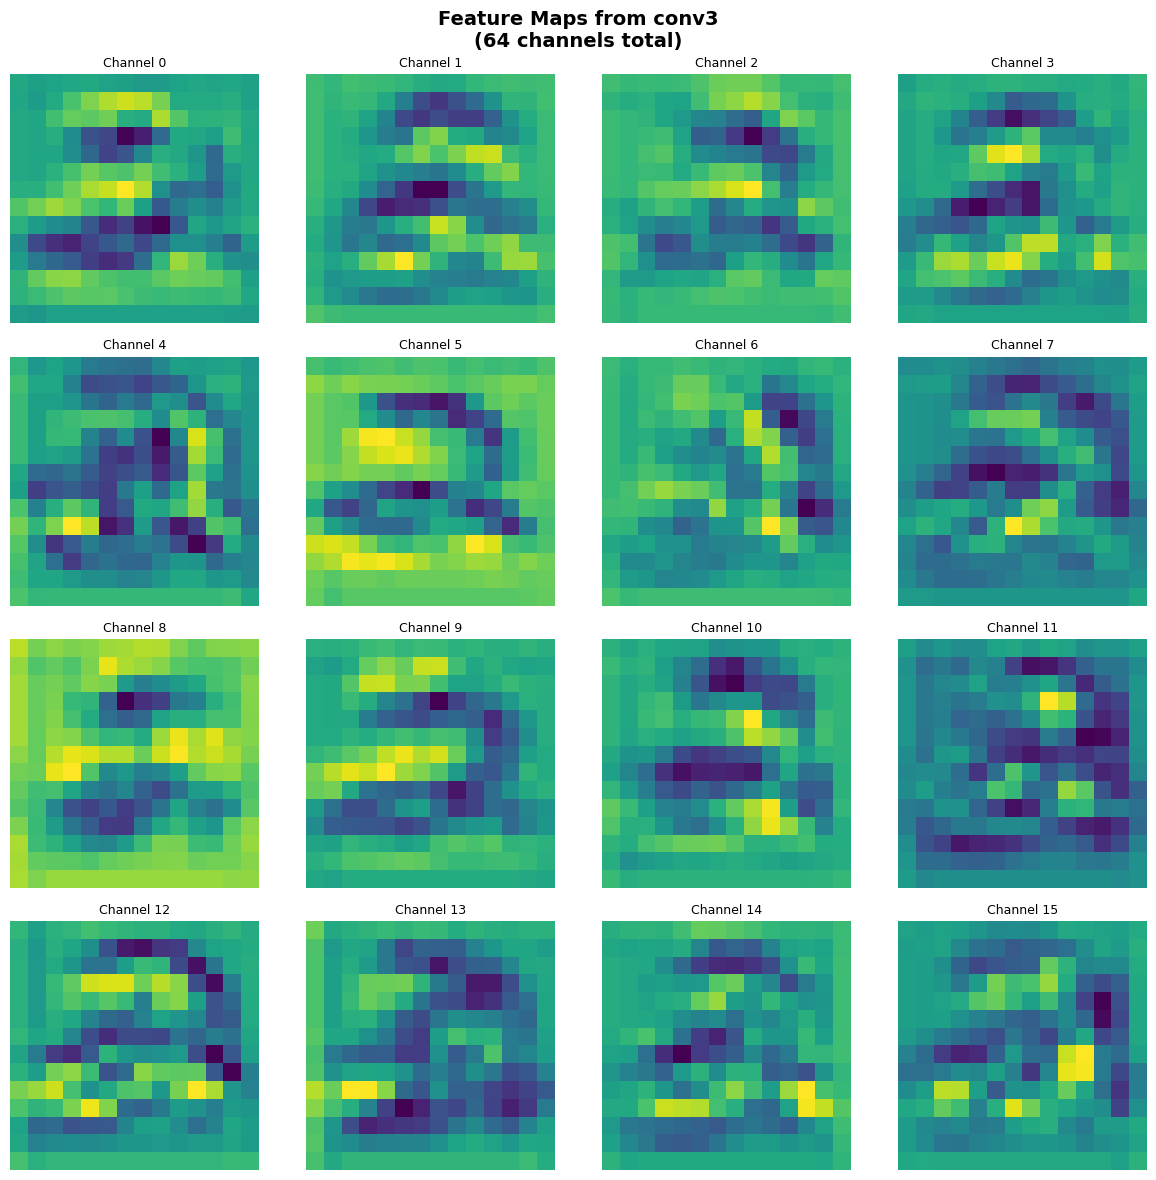


Showing detailed feature maps for Conv5...


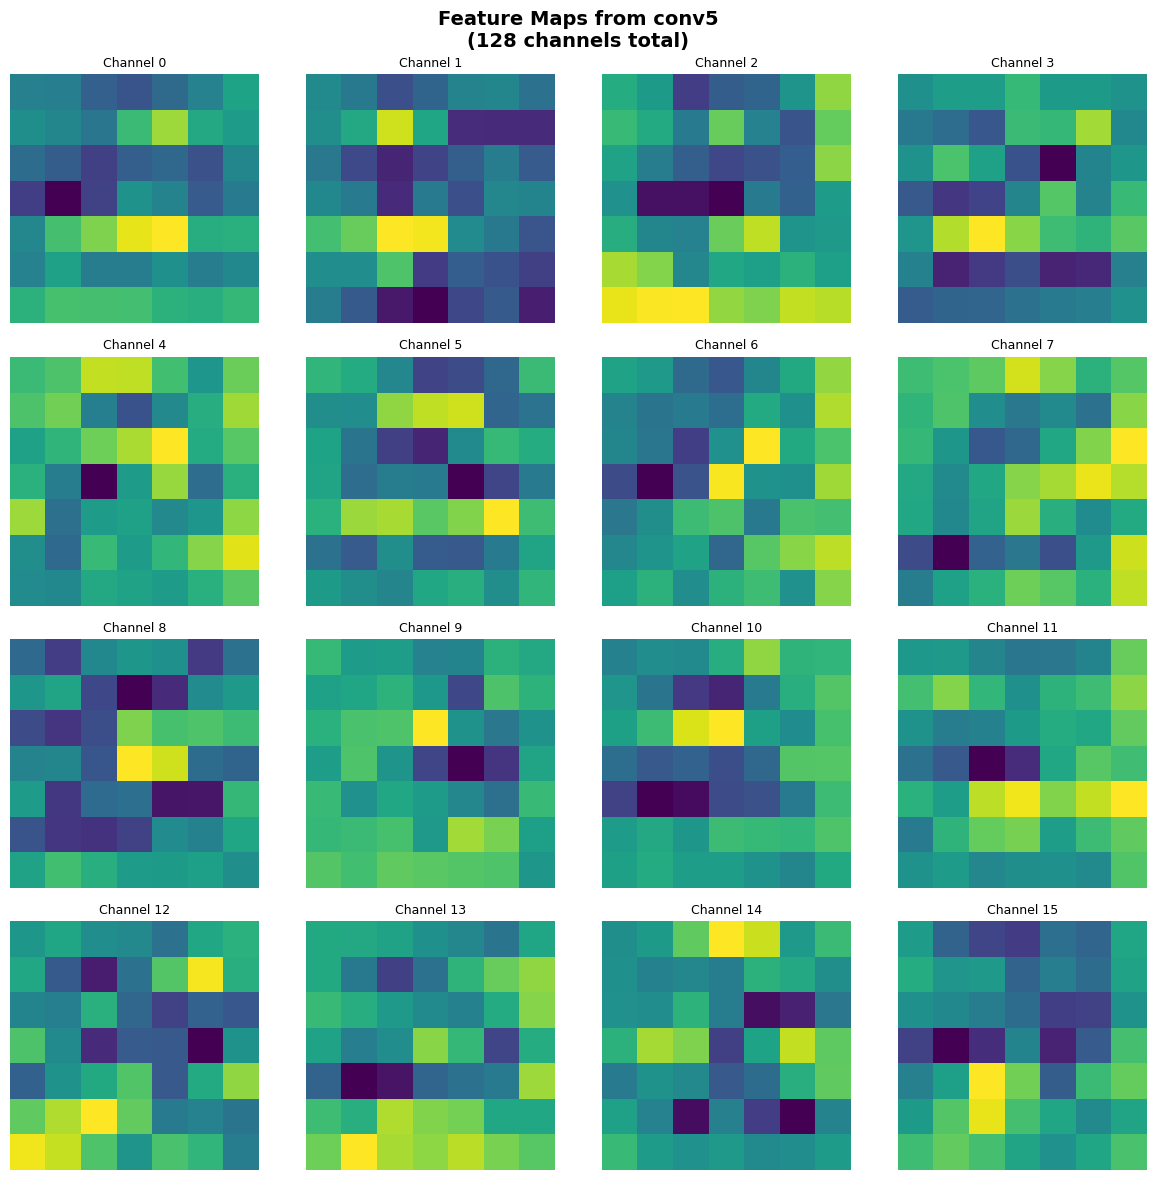


Processing Image #100


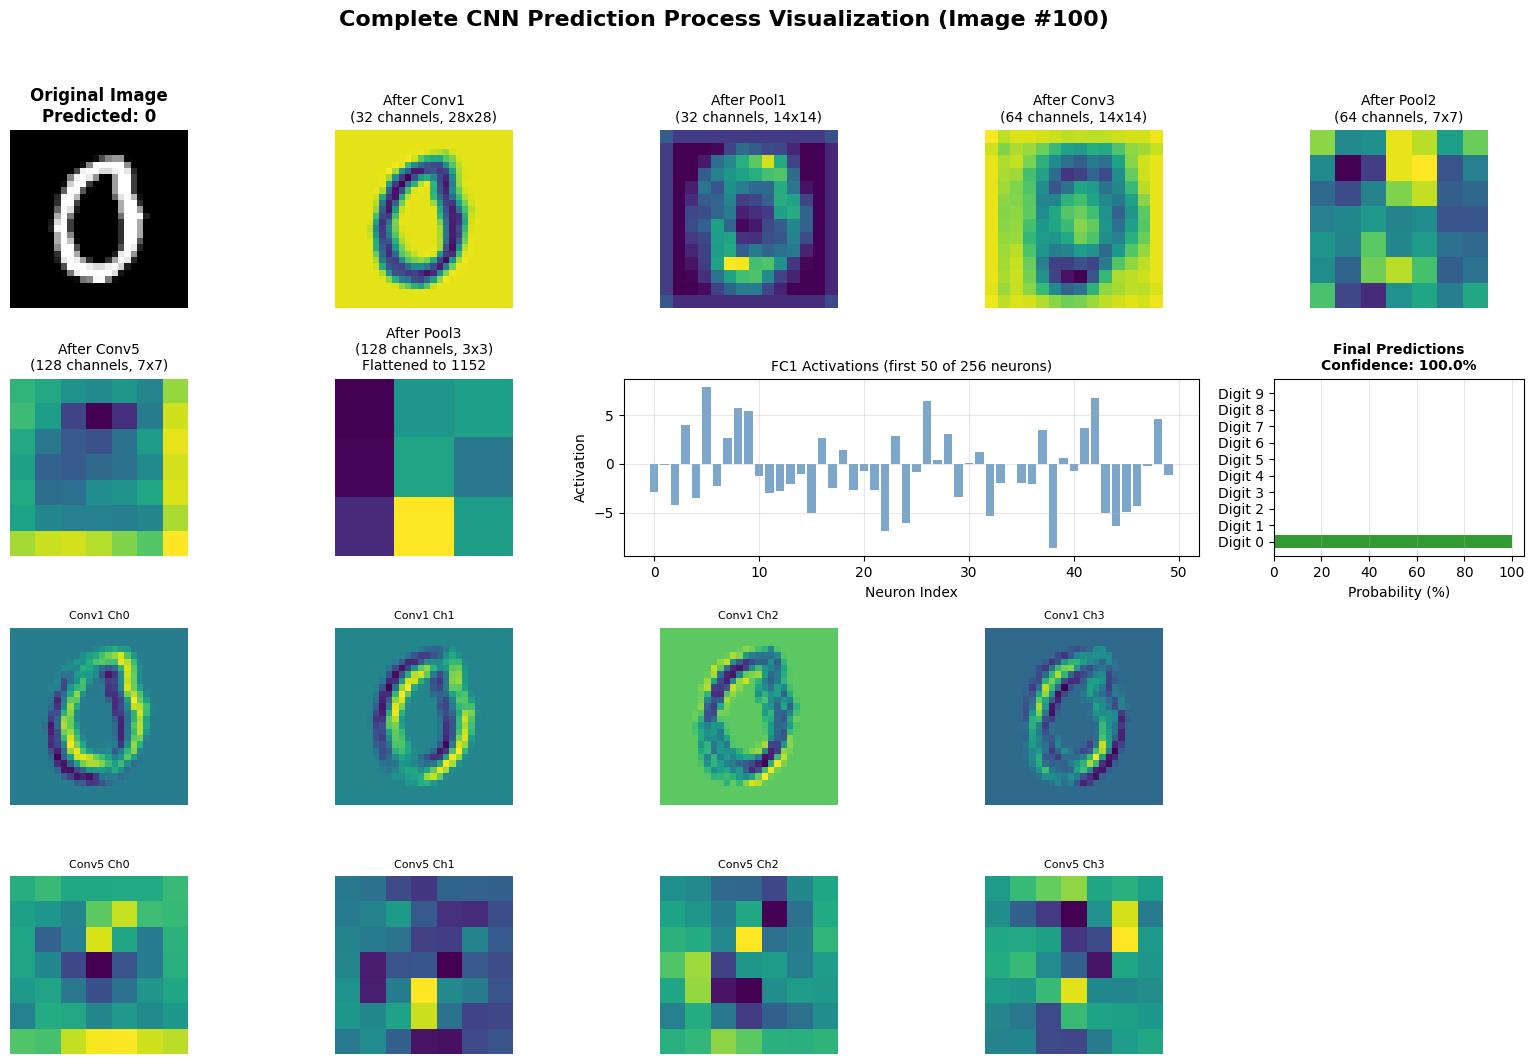

Predicted: 0 (Confidence: 100.00%)

Processing Image #500


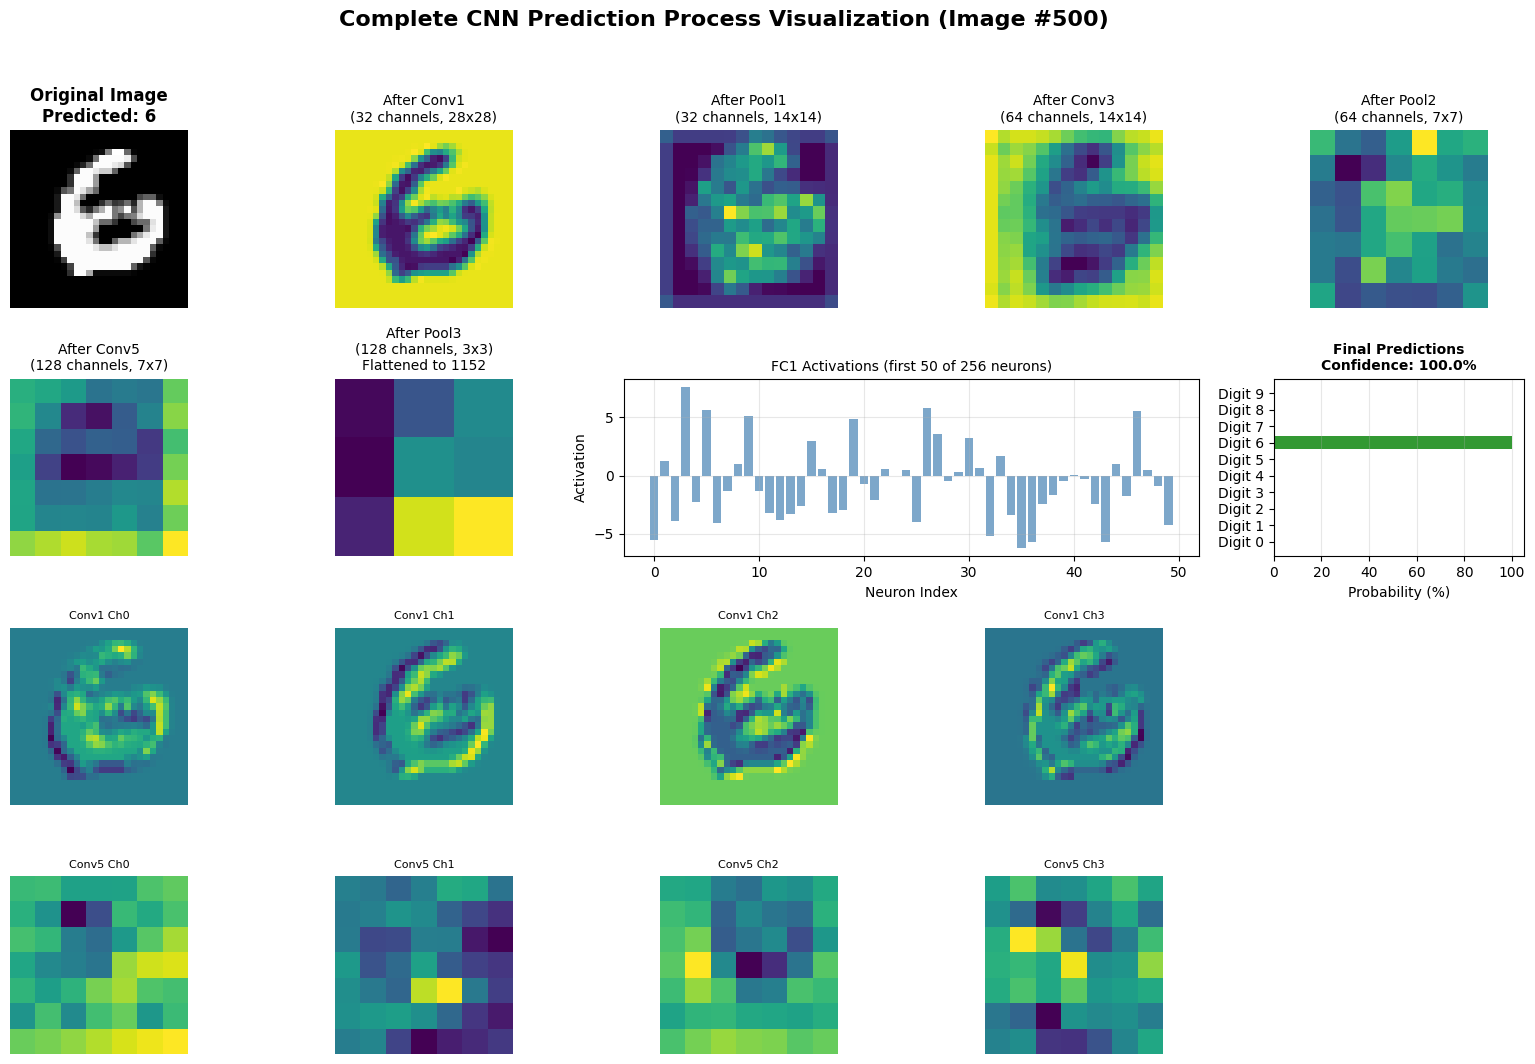

Predicted: 6 (Confidence: 100.00%)

Processing Image #1000


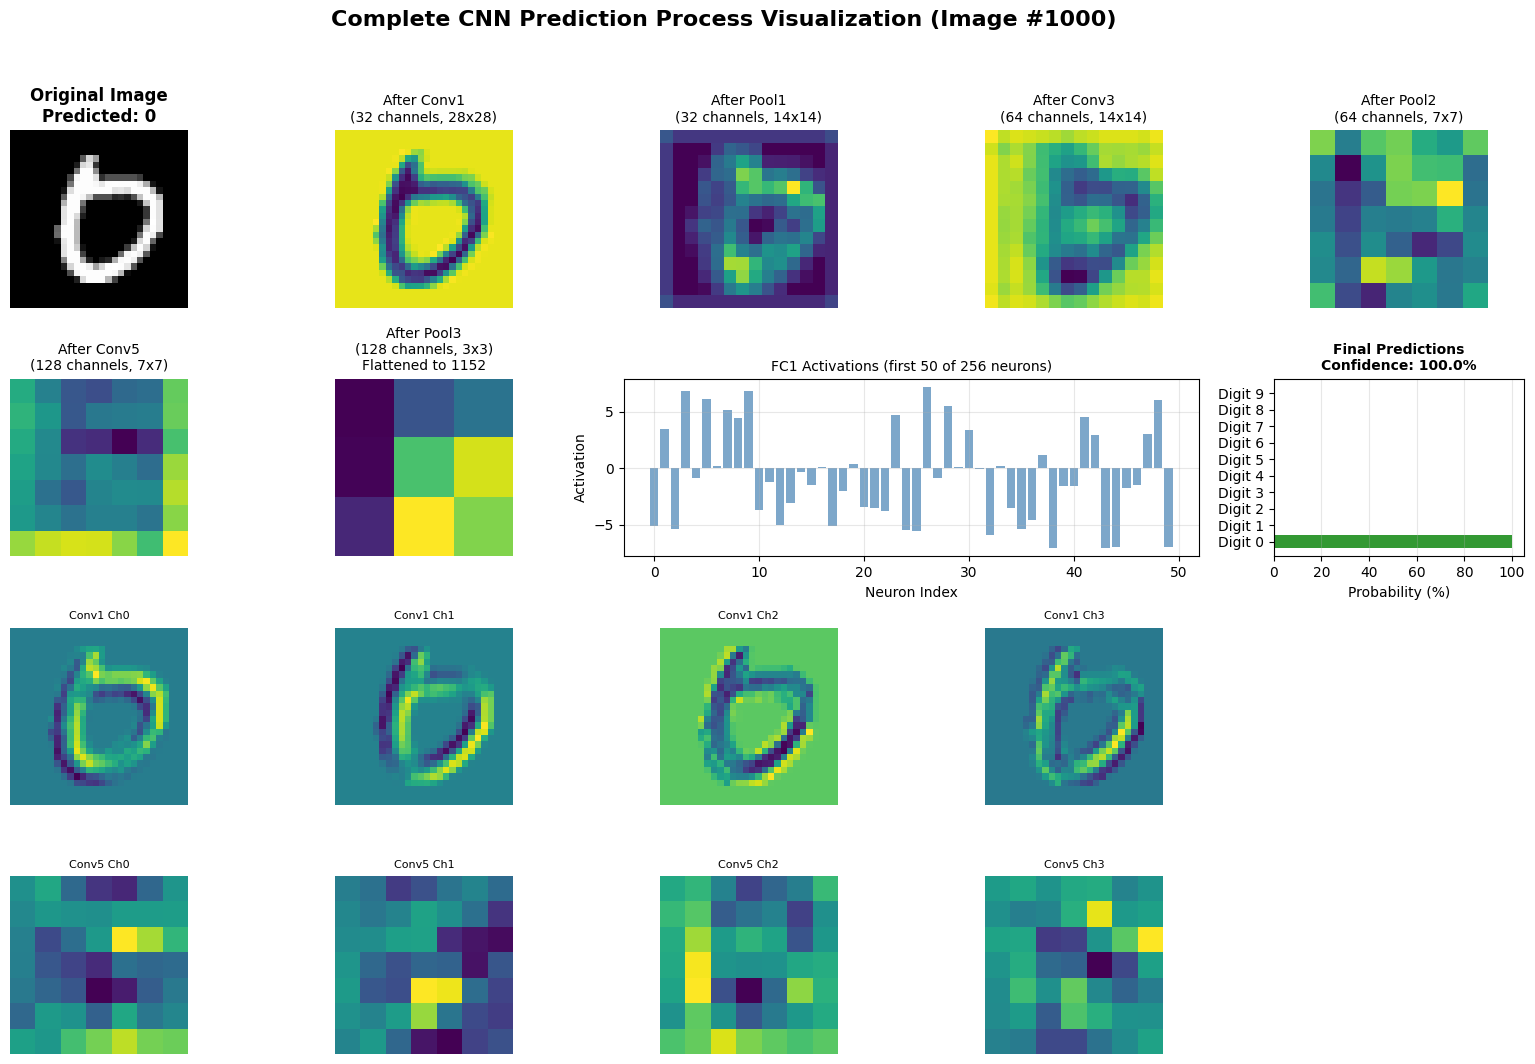

Predicted: 0 (Confidence: 100.00%)

Processing Image #2000


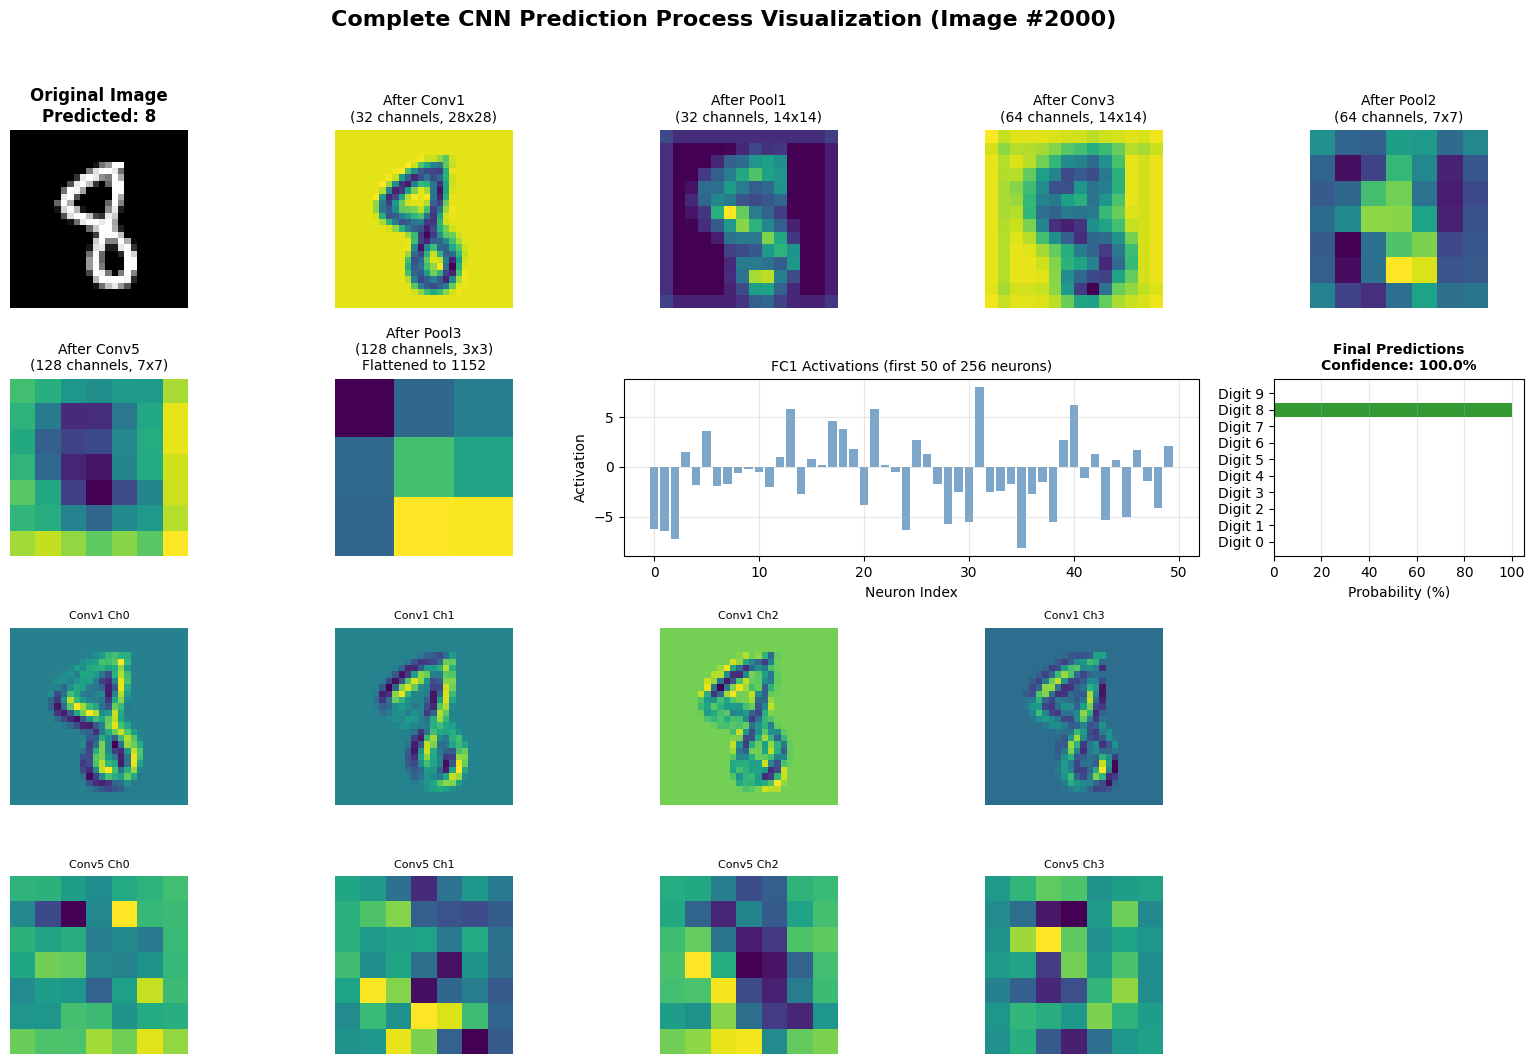

Predicted: 8 (Confidence: 100.00%)

Sample visualizations complete!


In [10]:
# Select some sample images to visualize
sample_indices = [0, 100, 500, 1000, 2000]

print("Visualizing prediction process for sample images...")
print("This will take some time due to detailed visualization.\n")

for idx in sample_indices:
    image = test_dataset[idx]
    print(f"\n{'='*60}")
    print(f"Processing Image #{idx}")
    print(f"{'='*60}")
    
    pred_class, confidence, features = visualize_complete_prediction(
        model, image, idx
    )
    
    print(f"Predicted: {pred_class} (Confidence: {confidence:.2f}%)")
    
    # Also show detailed feature maps for first sample
    if idx == sample_indices[0]:
        print("\nShowing detailed feature maps for Conv1...")
        visualize_feature_maps(image, features, 'conv1', num_maps=16, save_prefix=f'img{idx}')
        
        print("\nShowing detailed feature maps for Conv3...")
        visualize_feature_maps(image, features, 'conv3', num_maps=16, save_prefix=f'img{idx}')
        
        print("\nShowing detailed feature maps for Conv5...")
        visualize_feature_maps(image, features, 'conv5', num_maps=16, save_prefix=f'img{idx}')

print("\n" + "="*60)
print("Sample visualizations complete!")
print("="*60)

## 11. Activation Strength Analysis


Analyzing activation strength...


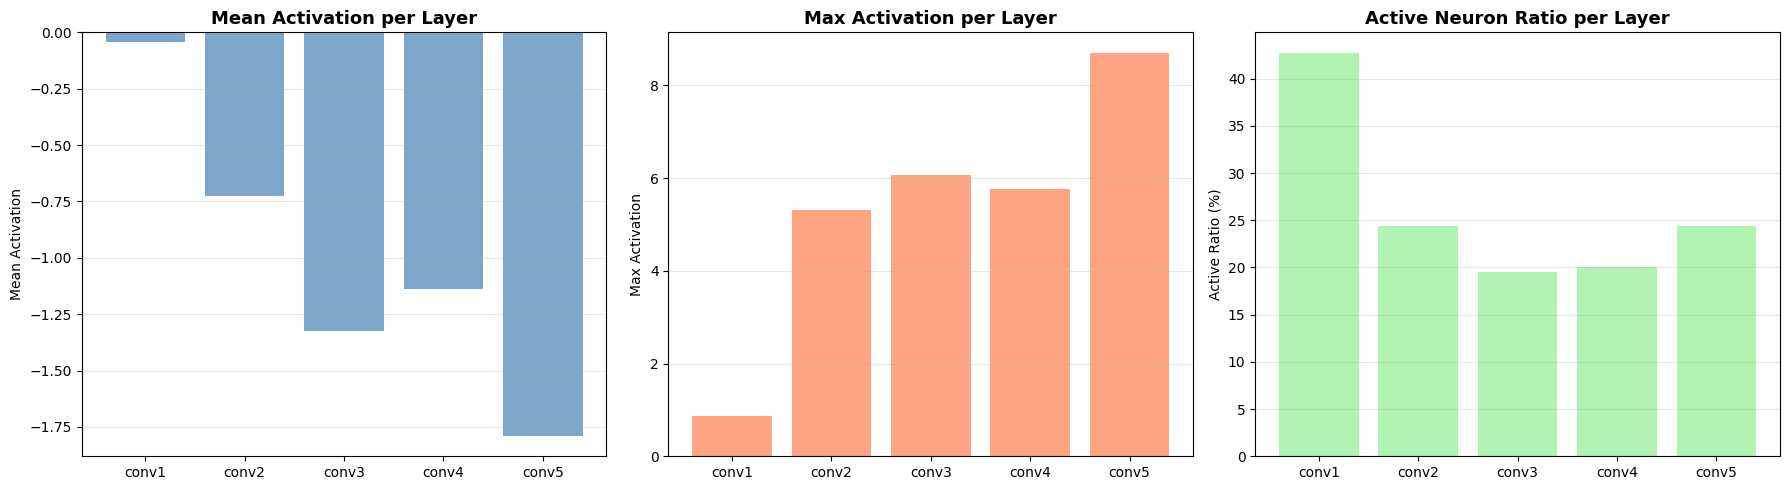


Layer Statistics:

conv1:
  mean: -0.0410
  std: 0.2527
  max: 0.8610
  min: -1.3007
  active_ratio: 42.7655

conv2:
  mean: -0.7263
  std: 1.2596
  max: 5.3167
  min: -7.7784
  active_ratio: 24.4141

conv3:
  mean: -1.3236
  std: 1.9408
  max: 6.0606
  min: -11.8381
  active_ratio: 19.4994

conv4:
  mean: -1.1397
  std: 1.4992
  max: 5.7556
  min: -7.2301
  active_ratio: 20.0973

conv5:
  mean: -1.7906
  std: 2.7253
  max: 8.7099
  min: -13.9737
  active_ratio: 24.3941


In [11]:
def analyze_activation_strength(features):
    """
    Analyze the activation strength across different layers
    """
    layer_stats = {}
    
    conv_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']
    
    for layer_name in conv_layers:
        if layer_name in features:
            feat = features[layer_name][0].cpu().numpy()  # First sample
            layer_stats[layer_name] = {
                'mean': feat.mean(),
                'std': feat.std(),
                'max': feat.max(),
                'min': feat.min(),
                'active_ratio': (feat > 0).mean() * 100  # % of activated neurons
            }
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    layers = list(layer_stats.keys())
    
    # Mean activation
    means = [layer_stats[l]['mean'] for l in layers]
    axes[0].bar(layers, means, color='steelblue', alpha=0.7)
    axes[0].set_title('Mean Activation per Layer', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Mean Activation')
    axes[0].grid(alpha=0.3, axis='y')
    
    # Max activation
    maxs = [layer_stats[l]['max'] for l in layers]
    axes[1].bar(layers, maxs, color='coral', alpha=0.7)
    axes[1].set_title('Max Activation per Layer', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Max Activation')
    axes[1].grid(alpha=0.3, axis='y')
    
    # Active ratio
    active_ratios = [layer_stats[l]['active_ratio'] for l in layers]
    axes[2].bar(layers, active_ratios, color='lightgreen', alpha=0.7)
    axes[2].set_title('Active Neuron Ratio per Layer', fontsize=13, fontweight='bold')
    axes[2].set_ylabel('Active Ratio (%)')
    axes[2].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['visualization_dir'], 'activation_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    return layer_stats

# Analyze for first sample
print("\nAnalyzing activation strength...")
image = test_dataset[0]
extractor = FeatureExtractor(model)
extractor.register_hooks()

with torch.no_grad():
    _ = model(image.unsqueeze(0).to(device))

features = extractor.get_features()
layer_stats = analyze_activation_strength(features)
extractor.remove_hooks()

print("\nLayer Statistics:")
for layer, stats in layer_stats.items():
    print(f"\n{layer}:")
    for key, value in stats.items():
        print(f"  {key}: {value:.4f}")

## 12. Generate Predictions for Test Set

In [12]:
print("Generating predictions for test set...")
print("This is faster as we skip visualization.\n")

model.eval()
predictions = []

with torch.no_grad():
    for images in tqdm(test_loader, desc='Predicting'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

predictions = np.array(predictions)
print(f"\nGenerated {len(predictions):,} predictions")

Generating predictions for test set...
This is faster as we skip visualization.



Predicting: 100%|██████████| 438/438 [00:01<00:00, 227.51it/s]


Generated 28,000 predictions


## 13. Create Submission File

In [13]:
# Create submission dataframe
submission = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

# Save to CSV
submission.to_csv(CONFIG['submission_path'], index=False)

print(f"Submission file saved to: {CONFIG['submission_path']}")
print(f"\nSubmission preview:")
print(submission.head(10))
print(f"\nPrediction distribution:")
print(submission['Label'].value_counts().sort_index())

Submission file saved to: submission.csv

Submission preview:
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3
5        6      7
6        7      0
7        8      3
8        9      0
9       10      3

Prediction distribution:
0    2771
1    3201
2    2805
3    2789
4    2756
5    2504
6    2739
7    2897
8    2755
9    2783
Name: Label, dtype: int64


## 14. Prediction Distribution Visualization

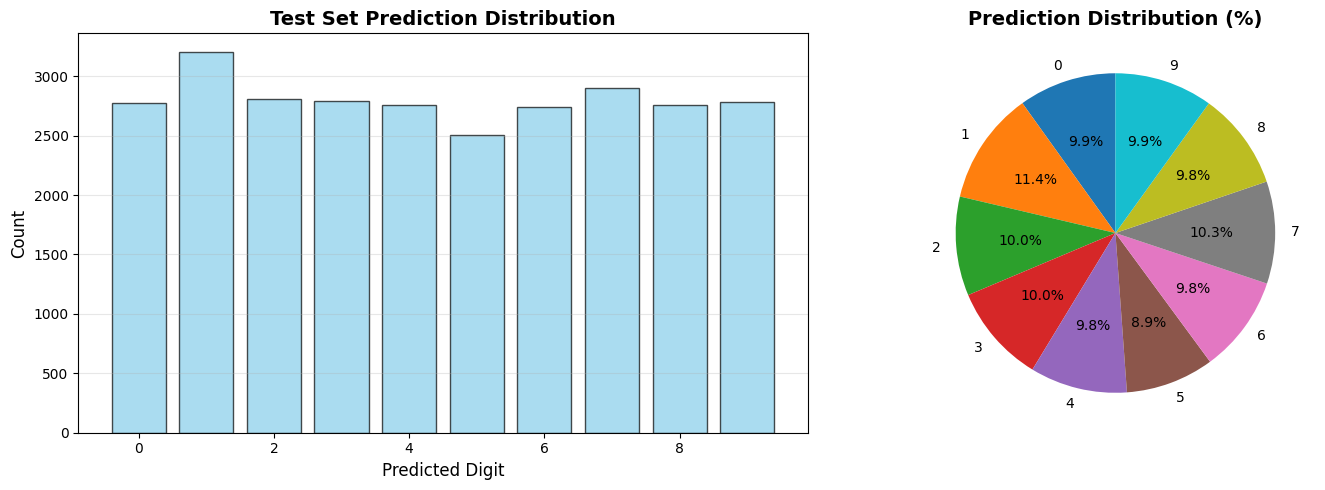

Prediction distribution visualization saved!


In [14]:
# Visualize prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

pred_counts = submission['Label'].value_counts().sort_index()

# Bar plot
axes[0].bar(pred_counts.index, pred_counts.values, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Predicted Digit', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Test Set Prediction Distribution', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Pie chart
axes[1].pie(pred_counts.values, labels=pred_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Prediction Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['visualization_dir'], 'test_prediction_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Prediction distribution visualization saved!")

## 15. Summary

In [15]:
print("="*70)
print("PREDICTION & VISUALIZATION SUMMARY")
print("="*70)
print(f"\nModel: CNN with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Test Samples: {len(predictions):,}")
print(f"\nVisualization Features:")
print("  - Learned filter visualization")
print("  - Layer-by-layer feature map extraction")
print("  - Complete prediction process visualization")
print("  - Activation strength analysis")
print("  - FC layer neuron activations")
print("  - Final prediction probabilities")
print(f"\nPrediction Statistics:")
for digit in range(10):
    count = (predictions == digit).sum()
    pct = 100 * count / len(predictions)
    print(f"  Digit {digit}: {count:5,} predictions ({pct:5.2f}%)")
print(f"\nOutput Files:")
print(f"  - Submission: {CONFIG['submission_path']}")
print(f"  - Visualizations: {CONFIG['visualization_dir']}")
print("="*70)
print("\nNote: The visualization shows the internal working of the CNN:")
print("  1. Input image passes through conv layers")
print("  2. Each layer extracts different features")
print("  3. Pooling layers reduce spatial dimensions")
print("  4. FC layers make final classification")
print("  5. Softmax produces class probabilities")
print("="*70)

PREDICTION & VISUALIZATION SUMMARY

Model: CNN with 437,738 parameters
Test Samples: 28,000

Visualization Features:
  - Learned filter visualization
  - Layer-by-layer feature map extraction
  - Complete prediction process visualization
  - Activation strength analysis
  - FC layer neuron activations
  - Final prediction probabilities

Prediction Statistics:
  Digit 0: 2,771 predictions ( 9.90%)
  Digit 1: 3,201 predictions (11.43%)
  Digit 2: 2,805 predictions (10.02%)
  Digit 3: 2,789 predictions ( 9.96%)
  Digit 4: 2,756 predictions ( 9.84%)
  Digit 5: 2,504 predictions ( 8.94%)
  Digit 6: 2,739 predictions ( 9.78%)
  Digit 7: 2,897 predictions (10.35%)
  Digit 8: 2,755 predictions ( 9.84%)
  Digit 9: 2,783 predictions ( 9.94%)

Output Files:
  - Submission: submission.csv
  - Visualizations: visualizations/

Note: The visualization shows the internal working of the CNN:
  1. Input image passes through conv layers
  2. Each layer extracts different features
  3. Pooling layers redu